In [14]:
import sys
import os
import io
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [15]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

load_dotenv('../.env')

def load_training_data():
    """Fetches all labeled parquet files from S3 and combines them."""
    bucket = os.getenv('S3_BUCKET_NAME')
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
        region_name='us-east-1'
    )
    
    print("Fetching labeled data from S3...")
    response = s3.list_objects_v2(Bucket=bucket, Prefix='training_data/')
    
    if 'Contents' not in response:
        print("No training data found.")
        return pd.DataFrame()
        
    dfs = []
    for obj in response['Contents']:
        if obj['Key'].endswith('.parquet'):
            data = s3.get_object(Bucket=bucket, Key=obj['Key'])['Body'].read()
            dfs.append(pd.read_parquet(io.BytesIO(data)))
            
    df = pd.concat(dfs, ignore_index=True)
    print(f"Successfully loaded {len(df)} labeled trades.")
    return df

df = load_training_data()
df.head()

Fetching labeled data from S3...
Successfully loaded 16042 labeled trades.


,company_name,ticker,contract_name,expiration_date,last_trade_date,stock_price,strike,premium,bid,ask,...,dividend_yield,snapshot_date,final_price,assigned,realized_value,realized_return_pct,target_profitable,days_held,realized_annual_return,target_high_quality
0,Shell PLC,SHEL,SHEL250417C00062500,2025-04-17,2025-04-07 19:10:05,59.760,62.5,2.15,1.10,1.25,...,4.47,2025-04-08,63.113800,True,64.650000,0.081827,True,9,3.318552,True
1,Enterprise Products Partners L.,EPD,EPD250417C00029000,2025-04-17,2025-04-08 18:42:35,28.950,29.0,1.03,1.05,1.11,...,6.94,2025-04-08,28.961407,False,29.991407,0.035973,True,9,1.458889,True
2,Enterprise Products Partners L.,EPD,EPD250417C00029500,2025-04-17,2025-04-08 16:22:00,28.950,29.5,0.95,0.77,0.83,...,6.94,2025-04-08,28.961407,False,29.911407,0.033209,True,9,1.346818,True
3,iShares Core S&P Total U.S. Sto,ITOT,ITOT250417C00121000,2025-04-17,2025-04-02 19:10:14,107.950,121.0,3.40,0.00,0.35,...,1.33,2025-04-08,113.768669,False,117.168669,0.085398,True,9,3.463346,True
4,Carnival Corporation,CCL,CCL250411C00026500,2025-04-11,2025-04-04 13:41:57,16.515,26.5,0.50,0.00,0.00,...,0.00,2025-04-08,17.639999,False,18.139999,0.098395,True,3,11.971436,True


In [16]:
def engineer_features(data):
    """Creates derived ratios and metrics for ML analysis."""
    d = data.copy()
    
    # 1. Distance to Strike (The Safety Cushion)
    # Positive means out-of-the-money (safer for covered calls)
    d['distance_to_strike_pct'] = (d['strike'] - d['stock_price']) / d['stock_price']
    
    # 2. Premium Yield (Reward)
    d['premium_yield'] = d['premium'] / d['stock_price']
    
    # 3. Liquidity Risk
    # High volume relative to open interest can signal a sudden breakout
    d['vol_oi_ratio'] = d['volume'] / (d['open_interest'] + 1)
    
    # 4. Days to Expiry (DTE)
    d['dte'] = (d['expiration_date'] - d['snapshot_date']).dt.days
    d['dte'] = d['dte'].replace(0, 1) # Prevent division by zero
    
    # 5. Annualized Yield
    d['annualized_yield'] = d['premium_yield'] * (365 / d['dte'])
    
    # 6. Risk-Adjusted Return
    # How much yield are we getting per unit of implied volatility?
    d['yield_to_iv_ratio'] = d['annualized_yield'] / (d['implied_volatility'] + 0.001)
    
    return d

df_ml = engineer_features(df)
print("Features engineered successfully.")

Features engineered successfully.


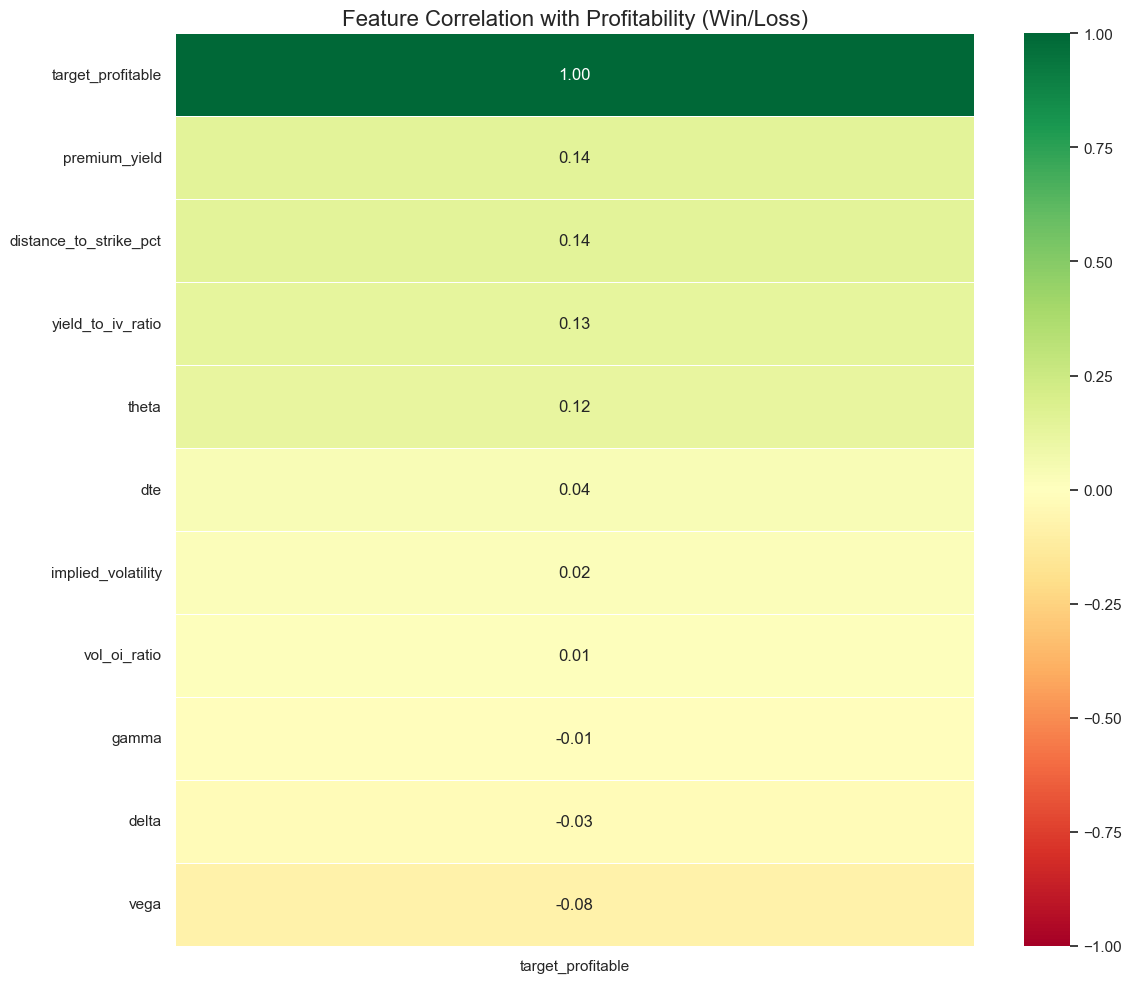

In [17]:
analysis_cols = [
    'delta', 'gamma', 'theta', 'vega', 'implied_volatility', 
    'distance_to_strike_pct', 'premium_yield', 'vol_oi_ratio', 
    'dte', 'yield_to_iv_ratio', 'target_profitable'
]

corr_matrix = df_ml[analysis_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix[['target_profitable']].sort_values(by='target_profitable', ascending=False), 
    annot=True, 
    cmap='RdYlGn', # Red (Negative) to Green (Positive)
    vmin=-1, 
    vmax=1,
    fmt=".2f",
    linewidths=.5
)
plt.title("Feature Correlation with Profitability (Win/Loss)", fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Loss (False)', 'Win (True)'])
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/r7/csk_79fx1pb0nd8bby20017c0000gn/T/ipykernel_55209/2969634369.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. af

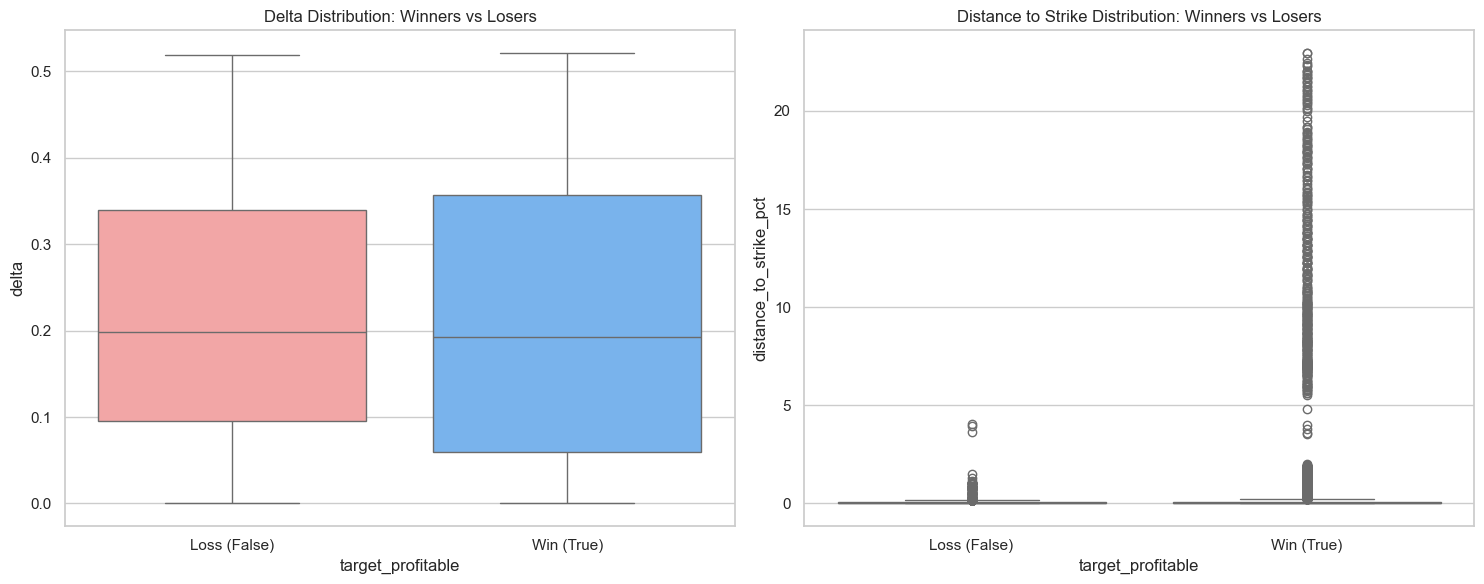

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Delta vs Profitability
sns.boxplot(
    data=df_ml, 
    x='target_profitable', 
    y='delta', 
    ax=axes[0],
    palette=['#ff9999', '#66b3ff']
)
axes[0].set_title("Delta Distribution: Winners vs Losers")
axes[0].set_xticklabels(['Loss (False)', 'Win (True)'])

# Plot 2: Distance to Strike vs Profitability
sns.boxplot(
    data=df_ml, 
    x='target_profitable', 
    y='distance_to_strike_pct', 
    ax=axes[1],
    palette=['#ff9999', '#66b3ff']
)
axes[1].set_title("Distance to Strike Distribution: Winners vs Losers")
axes[1].set_xticklabels(['Loss (False)', 'Win (True)'])

plt.tight_layout()
plt.show()

In [19]:
def audit_data_quality(df):
    print("--- 1. Missing & Infinite Values ---")
    # Check for NaNs (Missing data from Yahoo Finance)
    missing = df.isna().sum()
    print("Missing Values:\n", missing[missing > 0])
    
    # Check for Infinite values (Usually caused by division by zero in our engineered features)
    # We replace inf with NaN temporarily just to count them easily
    infs = df.replace([np.inf, -np.inf], np.nan).isna().sum() - missing
    print("\nInfinite Values:\n", infs[infs > 0])

    print("\n--- 2. Financial Logic Violations ---")
    # Options shouldn't have zero or negative premium
    bad_premiums = len(df[df['premium'] <= 0.01])
    print(f"Trades with premium <= $0.01: {bad_premiums}")
    
    # Implied Volatility should be positive and generally under 500% (5.0)
    # Anything higher is usually a low-liquidity glitch or a buyout
    crazy_iv = len(df[df['implied_volatility'] > 5.0])
    print(f"Trades with Implied Volatility > 500%: {crazy_iv}")
    
    # DTE (Days to Expiration) anomalies
    negative_dte = len(df[df['dte'] < 0])
    print(f"Trades with negative DTE (Data Leakage): {negative_dte}")

    print("\n--- 3. Extreme Outliers (The 1% and 99% quantiles) ---")
    # Absolute bounds of most correlated feature
    dist_min = df['distance_to_strike_pct'].quantile(0.01)
    dist_max = df['distance_to_strike_pct'].quantile(0.99)
    print(f"Distance to Strike 1st Percentile: {dist_min:.2%}")
    print(f"Distance to Strike 99th Percentile: {dist_max:.2%}")
    
    return df

df_audited = audit_data_quality(df_ml)

--- 1. Missing & Infinite Values ---
Missing Values:
 bid                 1
earnings_date    4759
dividend_date    5362
dtype: int64

Infinite Values:
 Series([], dtype: int64)

--- 2. Financial Logic Violations ---
Trades with premium <= $0.01: 0
Trades with Implied Volatility > 500%: 0
Trades with negative DTE (Data Leakage): 0

--- 3. Extreme Outliers (The 1% and 99% quantiles) ---
Distance to Strike 1st Percentile: 0.07%
Distance to Strike 99th Percentile: 1102.02%


In [20]:
def clean_dataset(df):
    print(f"Original row count: {len(df)}")
    
    df_clean = df.dropna(subset=['bid']).copy()
    
    # Filter out absurd strikes
    # For a covered call, selling a strike more than 50% away from the stock price 
    # is usually not a real trade (premium is too low). 
    df_clean = df_clean[df_clean['distance_to_strike_pct'] <= 0.50]
    
    print(f"Cleaned row count: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    return df_clean

df_ml_clean = clean_dataset(df_ml)

print(f"New Max Distance: {df_ml_clean['distance_to_strike_pct'].max():.2%}")

Original row count: 16042
Cleaned row count: 14796
Rows removed: 1246
New Max Distance: 49.68%


In [21]:
def add_macro_features(df):
    print("Fetching macro data (VIX & SPY)...")
    
    start_date = df['snapshot_date'].min() - pd.Timedelta(days=14) 
    end_date = df['snapshot_date'].max() + pd.Timedelta(days=2)
    
    # Download data
    vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)
    
    # Create DataFrame using the index from the downloaded data to avoid the ValueError
    macro_df = pd.DataFrame(index=spy_data.index)
    macro_df['vix'] = vix_data['Close']
    macro_df['spy_price'] = spy_data['Close']
    
    # Calculate trend
    macro_df['spy_5d_return'] = macro_df['spy_price'].pct_change(periods=5)
    
    # Rest of the merge logic...
    macro_df = macro_df.reset_index().rename(columns={'Date': 'snapshot_date'})
    macro_df['snapshot_date'] = pd.to_datetime(macro_df['snapshot_date']).dt.tz_localize(None)
    
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date']).dt.tz_localize(None)
    df_merged = pd.merge(df, macro_df[['snapshot_date', 'vix', 'spy_5d_return']], on='snapshot_date', how='left')
    
    return df_merged.ffill().dropna(subset=['vix', 'spy_5d_return'])

df_ml_clean = add_macro_features(df_ml_clean)

Fetching macro data (VIX & SPY)...


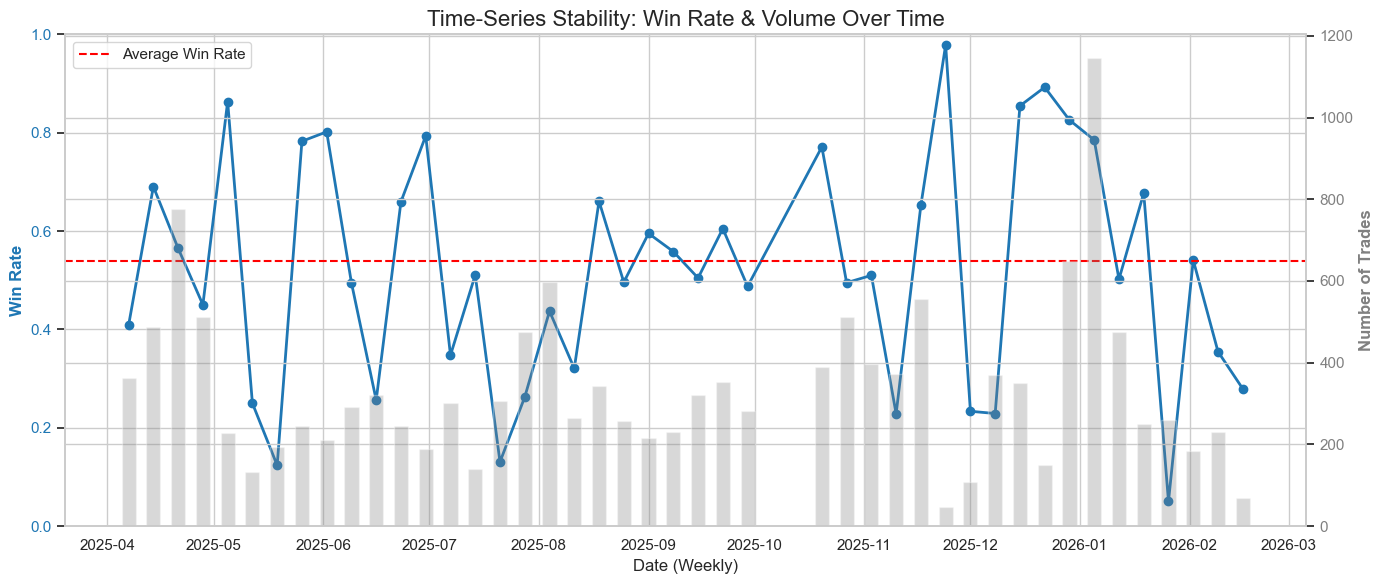

In [22]:
# Ensure snapshot_date is a datetime object
df_ml_clean['snapshot_date'] = pd.to_datetime(df_ml_clean['snapshot_date'])

# Group by week ('W') to calculate win rate and total trade volume
weekly_stats = df_ml_clean.groupby(df_ml_clean['snapshot_date'].dt.to_period('W')).agg(
    win_rate=('target_profitable', 'mean'),
    trade_count=('target_profitable', 'count')
).reset_index()

# Convert the period back to a standard date for plotting
weekly_stats['snapshot_date'] = weekly_stats['snapshot_date'].dt.start_time

# Set up the plot with two Y-axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot 1: Win Rate (Blue Line)
color = '#1f77b4'
ax1.set_xlabel('Date (Weekly)')
ax1.set_ylabel('Win Rate', color=color, fontweight='bold')
ax1.plot(weekly_stats['snapshot_date'], weekly_stats['win_rate'], color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=df_ml_clean['target_profitable'].mean(), color='red', linestyle='--', label='Average Win Rate')
ax1.set_ylim(0, 1.0) # Win rate is between 0 and 100%
ax1.legend(loc='upper left')

# Plot 2: Trade Volume (Gray Bars)
ax2 = ax1.twinx()  
color = 'gray'
ax2.set_ylabel('Number of Trades', color=color, fontweight='bold')  
ax2.bar(weekly_stats['snapshot_date'], weekly_stats['trade_count'], width=4, alpha=0.3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Time-Series Stability: Win Rate & Volume Over Time', fontsize=16)
fig.tight_layout()  
plt.show()